# Neural Network Sample

## Building a neural network

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from statistics import mean
from typing import Dict, List, Tuple

np.random.seed(7191)

class Neural:

    def __init__(self, layers: List[int], epochs: int,
                 learning_rate: float = 0.001, batch_size: int=32,
                 validation_split: float = 0.2, verbose: int=1):
        self._layer_structure: List[int] = layers
        self._batch_size: int = batch_size
        self._epochs: int = epochs
        self._learning_rate: float = learning_rate
        self._validation_split: float = validation_split
        self._verbose: int = verbose
        self._losses: Dict[str, float] = {"train": [], "validation": []}
        self._is_fit: bool = False
        self.__layers = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        # validation split
        X, X_val, y, y_val = train_test_split(X, y, test_size=self._validation_split, random_state=42)
        # initialization of layers
        self.__layers = self.__init_layers()
        for epoch in range(self._epochs):
            epoch_losses = []
            for i in range(1, len(self.__layers)):
                # forward pass
                x_batch = X[i:(i+self._batch_size)]
                y_batch = y[i:(i+self._batch_size)]
                pred, hidden = self.__forward(x_batch)
                # calculate loss
                loss = self.__calculate_loss(y_batch, pred)
                epoch_losses.append(np.mean(loss ** 2))
                #backward
                self.__backward(hidden, loss)
            valid_preds, _ = self.__forward(X_val)
            train_loss = mean(epoch_losses)
            valid_loss = np.mean(self.__calculate_mse(valid_preds,y_val))
            self._losses["train"].append(train_loss)
            self._losses["validation"].append(valid_loss)
            if self._verbose:
                print(f"Epoch: {epoch} Train MSE: {train_loss} Valid MSE: {valid_loss}")
        self._is_fit = True
        return

    def predict(self, X: np.ndarray) -> np.ndarray:
        if self._is_fit == False:
            raise Exception("Model has not been trained yet.")
        pred, hidden = self.__forward(X)
        return pred

    def plot_learning(self) -> None:
        plt.plot(self._losses["train"],label="loss")
        plt.plot(self._losses["validation"],label="validation")
        plt.legend()

    def __init_layers(self) -> List[np.ndarray]:
        layers = []
        for i in range(1, len(self._layer_structure)):
            layers.append([
                np.random.rand(self._layer_structure[i-1], self._layer_structure[i]) / 5 - .1,
                np.ones((1,self._layer_structure[i]))
            ])
        return layers

    def __activation(self, x: np.ndarray) -> np.ndarray:
        # return np.maximum(x, 0)
        # return np.tanh(x)
        # return 1 / (1 + np.exp(-x))
        prob =  1 / (1 + np.exp(-x))
        
        #if random number is less than prob, return 1, else return -1
        return np.random.binomial(1, prob, size=x.shape) * 2 - 1


    def __activation_derivative(self, x: np.ndarray) -> np.ndarray:
        # return np.heaviside(x, 0)
        # return 1 - np.tanh(x) ** 2
        return self.__activation(x) * (1 - self.__activation(x))


    def __forward(self, batch: np.ndarray) -> Tuple[np.ndarray, List[np.ndarray]]:
        hidden = [batch.copy()]
        for i in range(len(self.__layers)):
            batch = np.matmul(batch, self.__layers[i][0]) + self.__layers[i][1]
            if i < len(self.__layers) - 1:
                # batch = np.maximum(batch, 0)
                batch = self.__activation(batch)
            # Store the forward pass hidden values for use in backprop
            hidden.append(batch.copy())
        return batch, hidden

    def __calculate_loss(self,actual: np.ndarray, predicted: np.ndarray) -> np.ndarray:
        "mse"
        return predicted - actual


    def __calculate_mse(self, actual: np.ndarray, predicted: np.ndarray) -> np.ndarray:
        return (actual - predicted) ** 2

    def __backward(self, hidden: List[np.ndarray], grad: np.ndarray) -> None:
        for i in range(len(self.__layers)-1, -1, -1):
            if i != len(self.__layers) - 1:
                # grad = np.multiply(grad, np.heaviside(hidden[i+1], 0))
                grad = np.multiply(grad, self.__activation_derivative(hidden[i+1]))

            w_grad = hidden[i].T @ grad
            b_grad = np.mean(grad, axis=0)

            self.__layers[i][0] -= w_grad * self._learning_rate
            self.__layers[i][1] -= b_grad * self._learning_rate

            if(self._verbose):
              print('**********************')
              print(grad)
              print(self.__layers[i][0])
              print('**********************')

            grad = grad @ self.__layers[i][0].T
        return
#Let’s generate some dummy data to test the Neural.

def generate_data():
    # Define correlation values
    corr_a = 0.8
    corr_b = 0.4
    corr_c = -0.2

    # Generate independent features
    a = np.random.normal(0, 1, size=100000)
    b = np.random.normal(0, 1, size=100000)
    c = np.random.normal(0, 1, size=100000)
    d = np.random.randint(0, 4, size=100000)
    e = np.random.binomial(1, 0.5, size=100000)

    # Generate target feature based on independent features
    target = 50 + corr_a*a + corr_b*b + corr_c*c + d*10 + 20*e + np.random.normal(0, 10, size=100000)

    # Create DataFrame with all features
    df = pd.DataFrame({'a': a, 'b': b, 'c': c, 'd': d, 'e': e, 'target': target})
    return df

## Fitting the model on randomly generated data

**********************
[[ -78.10943221]
 [ -66.31032746]
 [ -91.10783644]
 [ -63.54842532]
 [ -62.43860773]
 [-113.20847282]
 [-129.46855806]
 [ -93.34434575]
 [ -53.90972086]
 [ -61.22553036]
 [-120.64201007]
 [ -76.91625483]
 [ -96.81035374]
 [ -48.37012013]
 [ -55.19700017]
 [-108.5138129 ]
 [-109.42506918]
 [ -51.81618271]
 [ -63.89341799]
 [ -82.41775398]
 [ -58.47459092]
 [ -64.04597536]
 [ -91.56811077]
 [ -68.01904438]
 [ -57.68109318]
 [ -68.67037005]
 [ -38.25769537]
 [ -73.01374459]
 [ -85.95701453]
 [ -85.5278442 ]
 [ -72.2554962 ]
 [ -75.62316011]
 [ -93.0235248 ]
 [ -52.27941676]
 [ -57.26813458]
 [ -49.54693757]
 [ -56.56190366]
 [ -99.45881397]
 [ -67.65543079]
 [ -86.77187789]
 [ -51.63535735]
 [ -88.69768201]
 [ -76.86211012]
 [ -60.40922751]
 [ -72.39922417]
 [ -63.54991466]
 [ -73.38183866]
 [ -94.1882727 ]
 [ -55.22689145]
 [-104.57619095]
 [ -69.49436847]
 [ -43.95008178]
 [ -84.04215979]
 [ -85.55601101]
 [ -76.97638779]
 [ -61.84103177]
 [ -51.8569826 ]
 [ -64.8

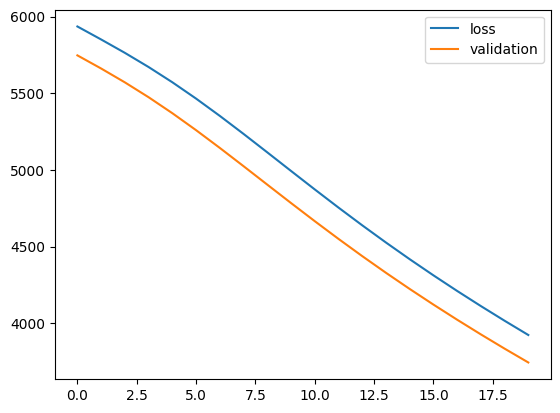

In [17]:
df = generate_data()

# Separate the features and target
X = df.drop('target', axis=1)
y = df['target']

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.to_numpy().reshape(-1,1)
y_test = y_test.to_numpy().reshape(-1,1)

layer_structure = [X_train.shape[1],10,10,1]
nn = Neural(layer_structure, 20, 1e-5, 64, 0.2, 1)

nn.fit(X_train, y_train)

y_pred = nn.predict(X_test)
nn.plot_learning()

print("Test error: ",mean_squared_error(y_test, y_pred))

### randomly generated data from above

In [18]:
df

,a,b,c,d,e,target
0,-0.336975,1.539382,0.085393,0,0,56.527071
1,0.140006,-0.042273,1.171705,0,1,78.159933
2,-1.035290,1.999564,0.995256,1,0,39.447661
3,-1.523176,-1.089355,1.575096,3,1,108.087030
4,1.190319,0.127029,-0.408177,1,1,68.289088
...,...,...,...,...,...,...
99995,0.594251,-2.039198,-0.767510,1,1,96.780264
99996,-1.563777,-0.350222,1.171843,0,1,56.308916
99997,0.772433,1.445736,-0.183360,0,0,50.282463
99998,-0.113206,-0.230634,-0.483486,3,1,106.890243


## Importing user/manual dataset and preprocessing according to the model

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import io
import requests

# Assume 'df' is your DataFrame with categorical variables
# Let's say 'categorical_columns' is a list of columns containing categorical data

label_encoder = LabelEncoder()

# drive.mount('/content/drive')

# # Load your dataset
url = 'https://raw.githubusercontent.com/wortcook/publicshares/refs/heads/main/2024FS-COMP_SCI-5567-0002/data.csv'
s = requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('utf-8')))


### Pre-processed data, ready to pass for model fitting.

In [20]:
df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


In [21]:
le = LabelEncoder()
df['diagnosis'] = le.fit_transform(df['diagnosis'])

df = df.drop('id',axis=1)
df =  df.drop('Unnamed: 32',axis=1)

In [22]:
df

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


## Fitting the model on the imported pre-processed dataset

### Feature extraction using correlation analysis against target variable

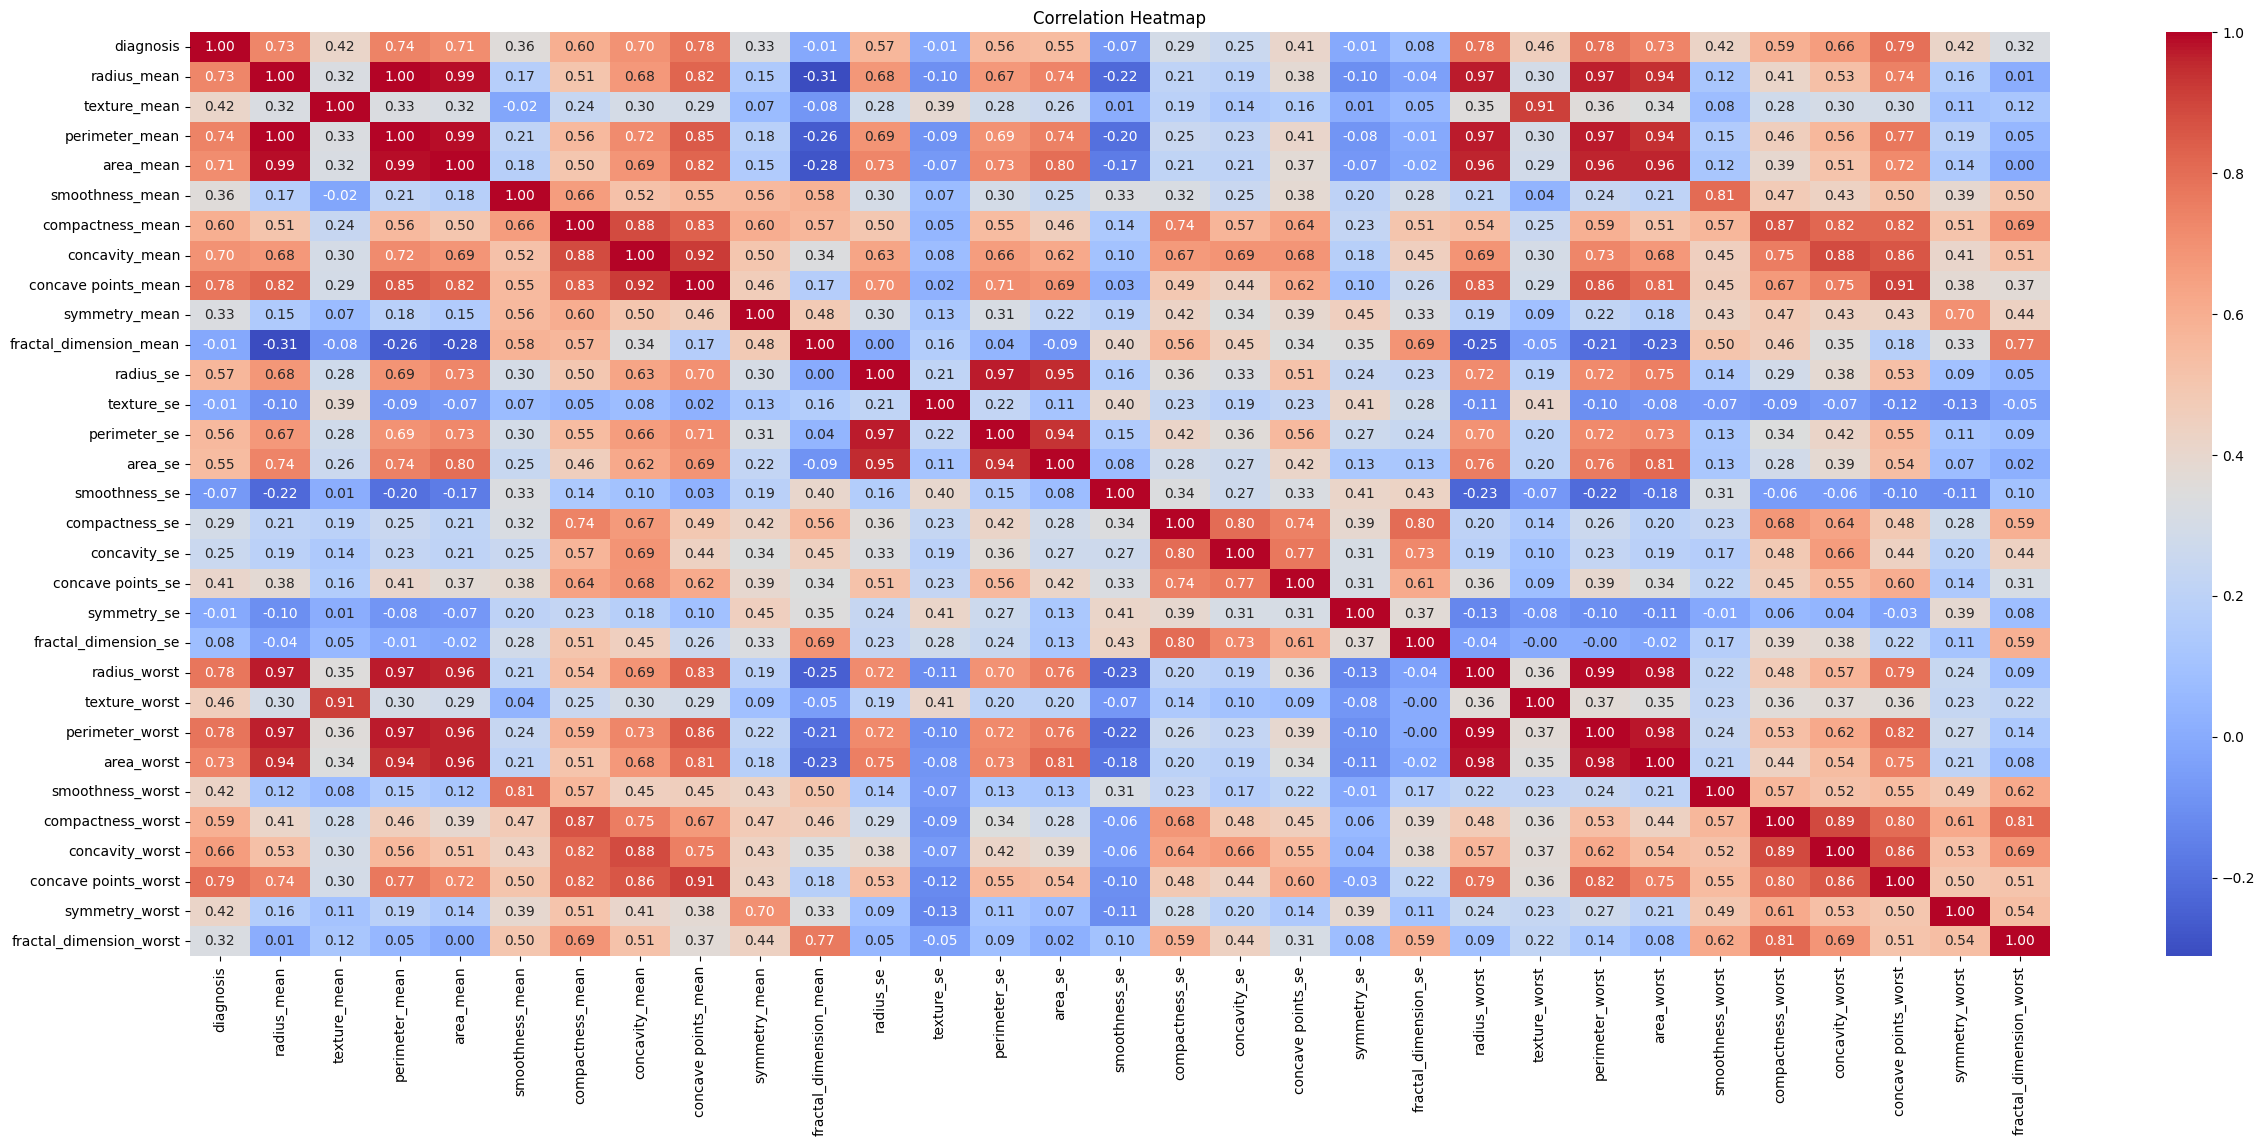

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt



# Calculate the correlation matrix
correlation_matrix = df.corr()
plt.figure(figsize=(30, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


### Feature extraction for model fitting

In [24]:
# Separate the features and target
X = df[['radius_mean','perimeter_mean','area_mean','concave points_worst','perimeter_worst','radius_worst','concave points_mean']]
y = df['diagnosis']

In [25]:
X

,radius_mean,perimeter_mean,area_mean,concave points_worst,perimeter_worst,radius_worst,concave points_mean
0,17.99,122.80,1001.0,0.2654,184.60,25.380,0.14710
1,20.57,132.90,1326.0,0.1860,158.80,24.990,0.07017
2,19.69,130.00,1203.0,0.2430,152.50,23.570,0.12790
3,11.42,77.58,386.1,0.2575,98.87,14.910,0.10520
4,20.29,135.10,1297.0,0.1625,152.20,22.540,0.10430
...,...,...,...,...,...,...,...
564,21.56,142.00,1479.0,0.2216,166.10,25.450,0.13890
565,20.13,131.20,1261.0,0.1628,155.00,23.690,0.09791
566,16.60,108.30,858.1,0.1418,126.70,18.980,0.05302
567,20.60,140.10,1265.0,0.2650,184.60,25.740,0.15200


In [26]:
y

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: int64

### Fitting the Neural network model on the extracted features against the target variable and fine tuning the hyperparameters that will be used to configure the model.

In [27]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.to_numpy().reshape(-1,1)
y_test = y_test.to_numpy().reshape(-1,1)


test_runs = [
    { #1
     'epochs' : 2000,
     'learn_rate' : 0.0003,
     'batch_size' : 20,
     'val_split' : 0.2,
     'verbose' : 0,
     'layer_structure' : [X_train.shape[1],2,2,1]
     },{ #2
     'epochs' : 4000,
     'learn_rate' : 0.0003,
     'batch_size' : 20,
     'val_split' : 0.2,
     'verbose' : 0,
     'layer_structure' : [X_train.shape[1],2,2,1]
     },{ #3
     'epochs' : 4000,
     'learn_rate' : 0.003,
     'batch_size' : 20,
     'val_split' : 0.2,
     'verbose' : 0,
     'layer_structure' : [X_train.shape[1],2,2,1]
     },{ #4
     'epochs' : 4000,
     'learn_rate' : 0.003,
     'batch_size' : 40,
     'val_split' : 0.2,
     'verbose' : 0,
     'layer_structure' : [X_train.shape[1],2,2,1]
     },{ #5
     'epochs' : 4000,
     'learn_rate' : 0.003,
     'batch_size' : 80,
     'val_split' : 0.2,
     'verbose' : 0,
     'layer_structure' : [X_train.shape[1],2,2,1]
     },{ #6
     'epochs' : 4000,
     'learn_rate' : 0.003,
     'batch_size' : 160,
     'val_split' : 0.2,
     'verbose' : 0,
     'layer_structure' : [X_train.shape[1],2,2,1]
     },{ #7
     'epochs' : 4000,
     'learn_rate' : 0.003,
     'batch_size' : 160,
     'val_split' : 0.4,
     'verbose' : 0,
     'layer_structure' : [X_train.shape[1],2,2,1]
     },{ #8
     'epochs' : 4000,
     'learn_rate' : 0.003,
     'batch_size' : 160,
     'val_split' : 0.4,
     'verbose' : 0,
     'layer_structure' : [X_train.shape[1],4,2,1]
     },{ #9
     'epochs' : 8000,
     'learn_rate' : 0.003,
     'batch_size' : 160,
     'val_split' : 0.4,
     'verbose' : 0,
     'layer_structure' : [X_train.shape[1],4,2,1]
     },{ #10
     'epochs' : 8000,
     'learn_rate' : 0.003,
     'batch_size' : 160,
     'val_split' : 0.4,
     'verbose' : 0,
     'layer_structure' : [X_train.shape[1],4,4,1]
     }
]

# epochs = 2000
# learn_rate = .0003
# batch_size = 20
# val_split = .2
# verbose = 0 #1

# layer_structure = [X_train.shape[1],4,4,1]

test_results = []

run_count = 5

for run in test_runs:
    run_stats = np.zeros((run_count,1))
    run_data = {'configuration' : run}

    for i in range(run_count):
      epochs = run['epochs']
      learn_rate = run['learn_rate']
      batch_size = run['batch_size']
      val_split = run['val_split']
      verbose = run['verbose']
      layer_structure = run['layer_structure']


      nn = Neural(layer_structure, epochs, learn_rate, batch_size, val_split, verbose)

      nn.fit(X_train, y_train)

      y_pred = nn.predict(X_test)
      run_stats[i] = mean_squared_error(y_test, y_pred)

      # print("Test error: ",run_stats[i])
    print("####################################")
    print("Configuration:")
    print(run)
    print("Average test error: ",np.mean(run_stats))
    print("Standard deviation of test error: ",np.std(run_stats))
    print("####################################")
    # nn.plot_learning()



####################################
Configuration:
{'epochs': 2000, 'learn_rate': 0.0003, 'batch_size': 20, 'val_split': 0.2, 'verbose': 0, 'layer_structure': [7, 2, 2, 1]}
Average test error:  0.06588024983285073
Standard deviation of test error:  0.012363380090683204
####################################
####################################
Configuration:
{'epochs': 4000, 'learn_rate': 0.0003, 'batch_size': 20, 'val_split': 0.2, 'verbose': 0, 'layer_structure': [7, 2, 2, 1]}
Average test error:  0.07041645942732186
Standard deviation of test error:  0.011345011774359051
####################################
####################################
Configuration:
{'epochs': 4000, 'learn_rate': 0.003, 'batch_size': 20, 'val_split': 0.2, 'verbose': 0, 'layer_structure': [7, 2, 2, 1]}
Average test error:  0.04378016237924171
Standard deviation of test error:  0.012343865961715763
####################################
####################################
Configuration:
{'epochs': 4000, 'learn_r